In [1]:
import json

from utils import read_lines

In [2]:
PATH = json.load(open('../path_config.json'))

#### Read XSum

In [3]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Evaluate Annotated Dataset

In [4]:
from tqdm import tqdm

In [5]:
data = json.load(open('../data/annotated_with_probability.json', 'r'))
print(len(data))

180


In [6]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11',
   'bart.large': 0.0215301513671875,
   'xsum_cmlm_bos': 0.02984619140625,
   'cnndm_cmlm_cedar': 0.007183074951171875,
   'bart.large.xsum': 0.0200347900390625,
   'cnndm_cmlm_scratch_cedar_warmup_20000': 3.2782554626464844e-06,
   'xsum_cmlm_scratch_cedar_warmup_10000': 0.190185546875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 1.9073486328125e-06,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.092529296875,
   'bart.large.cnn': 3.30805778503418e-05},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100',
   'bart.large': 0.05804443359375,
   'xsum_cmlm_bos': 0.0843505859375,
   'cnndm_cmlm_cedar': 0.01030731201171875,
   'bart.large.xsum': 0.06317138671875,
   'cnndm_cmlm_scratch_cedar_warmup_2

#### Prior/Posterior Distribution Diagram

In [7]:
%matplotlib inline

from draw import plot_scatter

In [8]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        e['prior'] = e['bart.large']
        e['posterior'] = e['xsum_cmlm_bos']
        prior_posterior.append(e)

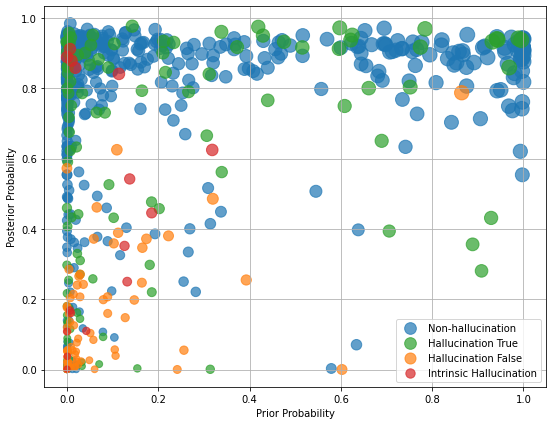

In [9]:
input_data = [
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]
]
labels = ['Non-hallucination', 'Hallucination True', 'Hallucination False', 'Intrinsic Hallucination']
plot_scatter(input_data, labels)

In [10]:
# for p in prior_posterior:
#     if p['prior'] > 0.9:
#         print(p)

#### Evaluate Baseline Models

In [11]:
from sklearn.metrics import classification_report

In [12]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'bart.large': 1.1265277862548828e-05,
 'xsum_cmlm_bos': 0.019073486328125,
 'cnndm_cmlm_cedar': 0.80859375,
 'bart.large.xsum': 0.0927734375,
 'cnndm_cmlm_scratch_cedar_warmup_20000': 0.0027942657470703125,
 'xsum_cmlm_scratch_cedar_warmup_10000': 0.00994110107421875,
 'cnndm_cmlm_scratch_cedar_warmup_10000': 0.00147247314453125,
 'xsum_cmlm_scratch_cedar_warmup_20000': 0.01239013671875,
 'bart.large.cnn': 1.7821788787841797e-05,
 'id': 8805,
 'prior': 1.1265277862548828e-05,
 'posterior': 0.019073486328125}

In [13]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [14]:
lm_baseline_preds = []
overlap_preds = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            overlap_preds.append(1)
        else:
            overlap_preds.append(0)

        if p['posterior'] > p['prior']:
            lm_baseline_preds.append(1)
        else:
            lm_baseline_preds.append(0)

In [15]:
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.3649    0.9390    0.5256        82
     Factual     0.9882    0.7581    0.8580       554

    accuracy                         0.7814       636
   macro avg     0.6766    0.8486    0.6918       636
weighted avg     0.9079    0.7814    0.8152       636



In [16]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.8436    0.9519    0.8945       187
    Hallucinated     0.9788    0.9265    0.9519       449

        accuracy                         0.9340       636
       macro avg     0.9112    0.9392    0.9232       636
    weighted avg     0.9391    0.9340    0.9350       636



In [17]:
print(classification_report(factual_label, lm_baseline_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1648    0.1829    0.1734        82
     Factual     0.8771    0.8628    0.8699       554

    accuracy                         0.7752       636
   macro avg     0.5209    0.5229    0.5216       636
weighted avg     0.7852    0.7752    0.7801       636



In [18]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], lm_baseline_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.3407    0.1658    0.2230       187
    Hallucinated     0.7138    0.8664    0.7827       449

        accuracy                         0.6604       636
       macro avg     0.5272    0.5161    0.5029       636
    weighted avg     0.6041    0.6604    0.6181       636



### KNN Evaluation

In [19]:
import numpy as np
import matplotlib

from sklearn import neighbors
from draw import plot, plot_three

In [20]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [21]:
hallucination_label_reverse = [1 if i == 0 else 0 for i in hallucination_label]
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, hallucination_label_reverse, n_neighbors=16)
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.6815    0.5722    0.6221       187
Non-hallucinated     0.8330    0.8886    0.8599       449

        accuracy                         0.7956       636
       macro avg     0.7573    0.7304    0.7410       636
    weighted avg     0.7885    0.7956    0.7900       636



In [22]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, factual_label, n_neighbors=12)
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.4889    0.5366    0.5116        82
     Factual     0.9304    0.9170    0.9236       554

    accuracy                         0.8679       636
   macro avg     0.7096    0.7268    0.7176       636
weighted avg     0.8735    0.8679    0.8705       636



In [23]:
font = {'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)

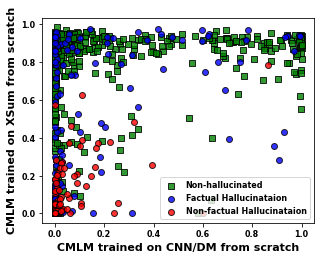

In [24]:
plot_three('entity_distribution_2cmlm',
           posterior_probabilities, prior_probabilities, true_label,
           colors=['green', 'blue', 'red'],
           legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
           n_neighbors=10,
           fig_size=(4.5, 3.5))

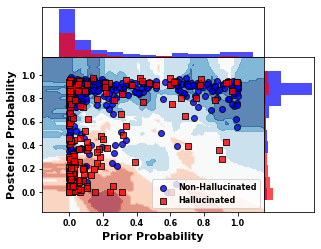

In [25]:
plot('Hallucination Entity Classification',
     posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-Hallucinated'])

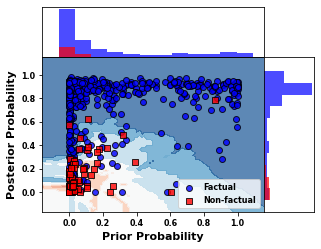

In [26]:
plot('compare_mlm_and_cmlm', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=12, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'])

#### Save KNN Model

In [27]:
import pickle

In [28]:
def build_KNN(posteriors, priors, labels, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    priors = np.array(priors)
    posteriors = np.array(posteriors)
    
#     x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
    x_mat = np.vstack([posteriors, priors]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [29]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, hallucination_label_reverse, n_neighbors=5)

In [30]:
preds = knn_classifier.predict(np.array(np.vstack([posterior_probabilities, prior_probabilities]).transpose()))

In [31]:
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.6778    0.3262    0.4404       187
     Factual     0.7692    0.9354    0.8442       449

    accuracy                         0.7563       636
   macro avg     0.7235    0.6308    0.6423       636
weighted avg     0.7423    0.7563    0.7255       636



In [32]:
# source, destination
pickle.dump(knn_classifier, open('classifiers/knn_mlm_cmlm_hallucination.pkl', 'wb'))

#### AUC

In [33]:
from draw import draw_auc

In [34]:
p1, p2, p3, p4, p5, p6, p7 = [], [], [], [], [], [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        p1.append(p['bart.large'])
        p2.append(p['xsum_cmlm_bos'])
        p3.append(p['xsum_cmlm_scratch_cedar_warmup_10000'])
        p4.append(p['cnndm_cmlm_cedar'])
        p5.append(p['cnndm_cmlm_scratch_cedar_warmup_10000'])
        p6.append(p['bart.large.xsum'])
        p7.append(p['bart.large.cnn'])

assert len(p1) == len(factual_label)

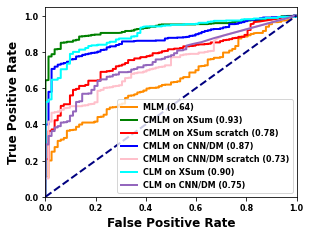

In [35]:
draw_auc(factual_label,
         [p1, p2, p3, p4, p5, p6, p7],
         ['MLM', 'CMLM on XSum', 'CMLM on XSum scratch', 'CMLM on CNN/DM', 'CMLM on CNN/DM scratch', 'CLM on XSum', 'CLM on CNN/DM'],
         ['darkorange', 'green', 'red', 'blue', 'pink', 'aqua', 'tab:purple'])

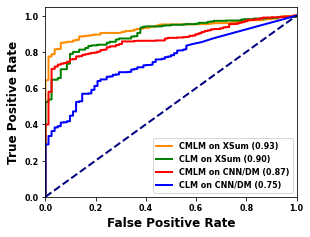

In [36]:
draw_auc(factual_label,
         [p2, p6, p4, p7],
         ['CMLM on XSum', 'CLM on XSum', 'CMLM on CNN/DM', 'CLM on CNN/DM'],
         ['darkorange', 'green', 'red', 'blue'])

In [37]:
# {
#     'start': 61,
#     'end': 74,
#     'label': 2,
#     'type': 'CARDINAL',
#     'ent': 'more than 100',
#     'bart.large': 0.024139404296875,
#     'xsum_cmlm_bos': 0.0843505859375,
#     'cnndm_cmlm_cedar': 0.01030731201171875,
#     'bart.large.xsum': 0.05517578125,
#     'cnndm_cmlm_scratch_cedar_warmup_20000': 1.6808509826660156e-05,
#     'xsum_cmlm_scratch_cedar_warmup_10000': 0.00960540771484375,
#     'cnndm_cmlm_scratch_cedar_warmup_10000': 4.7087669372558594e-05,
#     'xsum_cmlm_scratch_cedar_warmup_20000': 0.003948211669921875
# }